In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score



C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define constants
RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal", "Fraud"]

In [6]:
# Load the dataset
dataset = pd.read_csv("C:/Users/lang lab/Downloads/archive (18)creditcard.csv")

In [7]:
# Check for any null values
print("Any nulls in the dataset:", dataset.isnull().values.any())

Any nulls in the dataset: False


In [8]:
# Display unique labels
print("Number of unique labels:", len(dataset['Class'].unique()))
print("Label values:", dataset.Class.unique())


Number of unique labels: 2
Label values: [0 1]


In [9]:
# Visualize the imbalance in the dataset
print("Breakdown of Normal and Fraud Transactions:")
print(pd.value_counts(dataset['Class'], sort=True))

Breakdown of Normal and Fraud Transactions:
0    284315
1       492
Name: Class, dtype: int64


In [13]:
# Normalize Time and Amount columns
sc = StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

raw_data = dataset.values

In [14]:
raw_data = dataset.values

In [15]:
# The last element contains if the transaction is normal (0) or fraud (1)
labels = raw_data[:, -1]

In [16]:
# The other data points are the electrocardiogram data
data = raw_data[:, 0:-1]

In [17]:
# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=2021)


In [18]:
# Normalize the data to the range [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)


In [19]:
# Cast data to float32
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# Create boolean labels for normal and fraud
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [20]:

# Create datasets for normal and fraud records
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]

print("No. of records in Fraud Train Data =", len(fraud_train_data))
print("No. of records in Normal Train Data =", len(normal_train_data))
print("No. of records in Fraud Test Data =", len(fraud_test_data))
print("No. of records in Normal Test Data =", len(normal_test_data))

No. of records in Fraud Train Data = 389
No. of records in Normal Train Data = 227456
No. of records in Fraud Test Data = 103
No. of records in Normal Test Data = 56859


In [21]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1]
encoding_dim = 14
hidden_dim1 = int(encoding_dim / 2)
hidden_dim2 = 4
learning_rate = 1e-7

# Define the input layer
input_layer = tf.keras.layers.Input(shape=(input_dim,))

# Encoder layers
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim2, activation=tf.nn.leaky_relu)(encoder)


In [22]:
# Decoder layers
decoder = tf.keras.layers.Dense(hidden_dim1, activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

# Autoencoder model
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [23]:
# Model checkpoint
cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="autoencoder_fraud.h5",
    mode='min',
    monitor='val_loss',
    verbose=2,
    save_best_only=True
)


In [24]:
# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=11,
    mode='min',
    restore_best_weights=True
)


In [25]:
# Compile the autoencoder model
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

# Train the model
history = autoencoder.fit(
    normal_train_data,
    normal_train_data,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(test_data, test_data),
    verbose=1,
    callbacks=[cp, early_stop]
).history

Epoch 1/50
3502/3554 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.0384
Epoch 1: val_loss improved from inf to 0.00002, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 4s 1ms/step - loss: 0.0032 - accuracy: 0.0385 - val_loss: 1.9861e-05 - val_accuracy: 0.0472
Epoch 2/50
 136/3554 [>.............................] - ETA: 2s - loss: 2.0049e-05 - accuracy: 0.0368

C:\Users\lang lab\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3513/3554 [============================>.] - ETA: 0s - loss: 1.9336e-05 - accuracy: 0.0597
Epoch 2: val_loss did not improve from 0.00002
3554/3554 [==============================] - 4s 1ms/step - loss: 1.9334e-05 - accuracy: 0.0594 - val_loss: 1.9866e-05 - val_accuracy: 0.0363
Epoch 3/50
3522/3554 [============================>.] - ETA: 0s - loss: 1.9430e-05 - accuracy: 0.0644
Epoch 3: val_loss did not improve from 0.00002
3554/3554 [==============================] - 4s 1000us/step - loss: 1.9412e-05 - accuracy: 0.0645 - val_loss: 1.9931e-05 - val_accuracy: 0.0699
Epoch 4/50
3542/3554 [============================>.] - ETA: 0s - loss: 1.9367e-05 - accuracy: 0.0679
Epoch 4: val_loss did not improve from 0.00002
3554/3554 [==============================] - 4s 1ms/step - loss: 1.9366e-05 - accuracy: 0.0680 - val_loss: 2.0029e-05 - val_accuracy: 0.2168
Epoch 5/50
3552/3554 [============================>.] - ETA: 0s - loss: 1.9544e-05 - accuracy: 0.0585
Epoch 5: val_loss did not improve fr

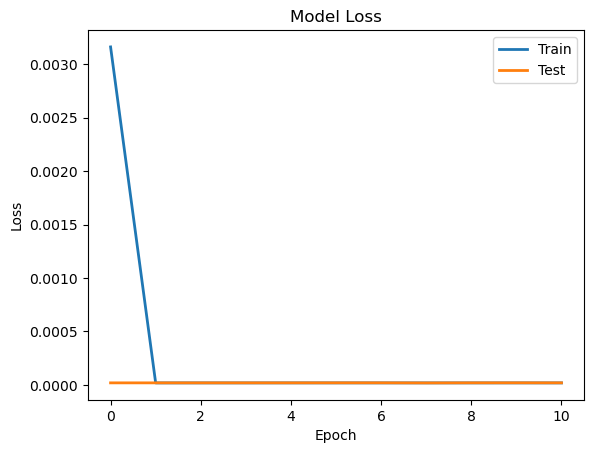

In [26]:
# Plot loss history
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [27]:
# Calculate reconstruction error and create a DataFrame
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': test_labels})



1781/1781 [==============================] - 1s 588us/step


In [28]:
# Set a fixed threshold for anomaly detection
threshold_fixed = 52
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] = pred_y


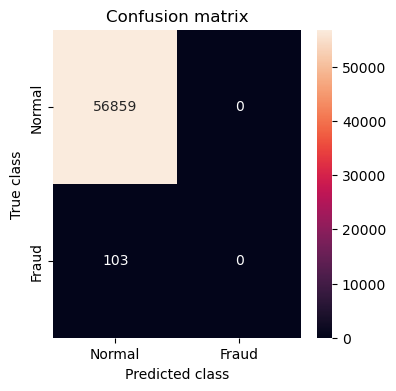

In [29]:
# Create and display a confusion matrix
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

In [30]:
# Print Accuracy, Precision, and Recall
print("Accuracy:", accuracy_score(error_df['True_class'], error_df['pred']))
print("Recall:", recall_score(error_df['True_class'], error_df['pred']))
print("Precision:", precision_score(error_df['True_class'], error_df['pred']))

Accuracy: 0.9981917769741231
Recall: 0.0
Precision: 0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
